In [1]:
import pandas as pd
import numpy as np
import requests

Get the time series for the following cryptocurrencies:
ETH
SOL
AVAX
USDT
FLOW

ETH, SOL, AVAX and USDT are available on coinbase-pro, whereas FLOW is available on kraken 

In [2]:
def get_data(token):
    if token in ['ETH', 'SOL', 'AVAX','USDT']:
        res = requests.get(
            f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
            params={
                'periods': '3600',
                'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
            }
        )
    else:
        res = requests.get(
            f'https://api.cryptowat.ch/markets/kraken/{token}usd/ohlc',
            params={
                'periods': '3600',
                'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
            }
        )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df


In [3]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']

In [4]:
df=[get_data(token) for token in tokens]

In [5]:
df_base = pd.concat(df, keys=tokens) #concatenate all dataframes into one

Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume

In [6]:
df_volumneUSD = df_base.groupby('token')['volumeUSD'].sum().to_frame()

In [7]:
df_volumneUSD.sort_values('volumeUSD', ascending=False)

,volumeUSD
token,
ETH,2.133783e+10
SOL,7.002544e+09
AVAX,3.455992e+09
USDT,1.993079e+09
FLOW,8.748559e+07


Add a column that calculates the close price ratio between ETH and SOL for each hour

In [8]:
df_ETH_SOL = pd.merge(
             df[0][['ts', 'close']].rename(columns={'close': f'close_{tokens[0]}'}),
             df[1][['ts', 'close']].rename(columns={'close': f'close_{tokens[1]}'}),
             on='ts',
             how='inner'
             )

In [9]:
df_ETH_SOL['close_price_ratio']=df_ETH_SOL['close_ETH']/df_ETH_SOL['close_SOL']

In [10]:
df_ETH_SOL

,ts,close_ETH,close_SOL,close_price_ratio
0,2021-11-22 00:00:00,4262.99,230.785,18.471694
1,2021-11-22 01:00:00,4234.37,226.000,18.736150
2,2021-11-22 02:00:00,4217.89,227.037,18.577985
3,2021-11-22 03:00:00,4193.47,223.117,18.794937
4,2021-11-22 04:00:00,4168.35,220.652,18.891059
...,...,...,...,...
544,2021-12-14 16:00:00,3786.61,157.700,24.011477
545,2021-12-14 17:00:00,3764.95,155.460,24.218127
546,2021-12-14 18:00:00,3760.58,153.920,24.432043
547,2021-12-14 19:00:00,3749.59,153.670,24.400273


Change the name of the `volume` and `volumeUSD` columns to `volumeBase` and `volumeTerm`

In [11]:
df_base.rename(columns={'volume':'volumeBase', 'volumeUSD':'volumeTerm'})

ts      open      high       low     close  \
ETH  0   2021-11-22 00:00:00  4317.980  4342.240  4246.070  4262.990   
     1   2021-11-22 01:00:00  4263.040  4270.340  4212.450  4234.370   
     2   2021-11-22 02:00:00  4234.870  4246.720  4171.170  4217.890   
     3   2021-11-22 03:00:00  4217.880  4223.480  4163.580  4193.470   
     4   2021-11-22 04:00:00  4192.950  4213.590  4147.000  4168.350   
...                      ...       ...       ...       ...       ...   
FLOW 543 2021-12-14 15:00:00     8.488     8.553     8.468     8.553   
     544 2021-12-14 16:00:00     8.544     8.572     8.443     8.459   
     545 2021-12-14 17:00:00     8.471     8.529     8.465     8.529   
     546 2021-12-14 18:00:00     8.506     8.543     8.476     8.476   
     547 2021-12-14 19:00:00     8.466     8.497     8.400     8.439   

            volumeBase    volumeTerm token  
ETH  0     7262.562789  3.123077e+07   ETH  
     1     8437.946084  3.574586e+07   ETH  
     2     9259.725370  3.895639e+07   ETH  
     3     9259.899519  3.882032e+07   ETH  
     4     7934.546906  3.315476e+07   ETH  
...                ...           ...   ...  
FLOW 543  12876.200967  1.093249e+05  FLOW  
     544   2263.360401  1.916800e+04  FLOW  
     545   2001.885968  1.700178e+04  FLOW  
     546   1388.531475  1.179238e+04  FLOW  
     547  13318.986369  1.126370e+05  FLOW  

[2742 rows x 8 columns]

create a fat table indexed by the timestamp, and each column is the close price of each token (i.e. this should be a table of  200 rows and 5 columns)

In [13]:
def clean_dataframe(original_df):
    cleaned_df = original_df.set_index('ts')['close'].rename(f'close_{original_df.token[0]}').to_frame()
    return cleaned_df 

In [14]:
cleaned_dataframes = [clean_dataframe(original_df) for original_df in df]

In [15]:
cleaned_dataframes[0]

,close_ETH
ts,
2021-11-22 00:00:00,4262.99
2021-11-22 01:00:00,4234.37
2021-11-22 02:00:00,4217.89
2021-11-22 03:00:00,4193.47
2021-11-22 04:00:00,4168.35
...,...
2021-12-14 16:00:00,3786.61
2021-12-14 17:00:00,3764.95
2021-12-14 18:00:00,3760.58


In [16]:
import functools 

In [18]:
joined_pdf = functools.reduce(lambda a, b: a.join(b), cleaned_dataframes)

In [19]:
joined_pdf

,close_ETH,close_SOL,close_AVAX,close_USDT,close_FLOW
ts,,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012,14.150
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013,13.621
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012,13.753
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011,13.652
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009,13.581
...,...,...,...,...,...
2021-12-14 16:00:00,3786.61,157.700,80.67,1.0003,8.459
2021-12-14 17:00:00,3764.95,155.460,80.84,1.0003,8.529
2021-12-14 18:00:00,3760.58,153.920,80.15,1.0003,8.476


calculate the hour by hour log return of the close price of each token

In [24]:
df_log_return = [(lambda x: x.assign(log_return=np.log(x.close)-np.log(x.close.shift(1))))(df_original) for df_original in df]

In [25]:
df_log_return[0]

,ts,open,high,low,close,volume,volumeUSD,token,log_return
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,NaN
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,-0.006736
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,-0.003900
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,-0.005806
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,-0.006008
...,...,...,...,...,...,...,...,...,...
544,2021-12-14 16:00:00,3819.45,3839.36,3770.05,3786.61,10205.473087,3.886460e+07,ETH,-0.008635
545,2021-12-14 17:00:00,3786.62,3803.20,3746.77,3764.95,12999.350024,4.917309e+07,ETH,-0.005737
546,2021-12-14 18:00:00,3764.75,3800.00,3756.33,3760.58,8525.088725,3.223840e+07,ETH,-0.001161
547,2021-12-14 19:00:00,3760.58,3784.91,3726.41,3749.59,7607.136587,2.854686e+07,ETH,-0.002927


calculate the correlation of the tokens using the table above

In [26]:
def clean_dataframe_2(original_df):
    cleaned_df = original_df.set_index('ts')['log_return'].rename(f'log_return_{original_df.token[0]}').to_frame()
    return cleaned_df 

In [30]:
clean_data_lr = [clean_dataframe_2(original_df) for original_df in df_log_return] #get cleaned log_return dataframes 

In [31]:
clean_data_lr[0]

,log_return_ETH
ts,
2021-11-22 00:00:00,NaN
2021-11-22 01:00:00,-0.006736
2021-11-22 02:00:00,-0.003900
2021-11-22 03:00:00,-0.005806
2021-11-22 04:00:00,-0.006008
...,...
2021-12-14 16:00:00,-0.008635
2021-12-14 17:00:00,-0.005737
2021-12-14 18:00:00,-0.001161


In [33]:
joined_pd_lr = functools.reduce(lambda a, b: a.join(b), clean_data_lr)

In [34]:
joined_pd_lr

,log_return_ETH,log_return_SOL,log_return_AVAX,log_return_USDT,log_return_FLOW
ts,,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,-0.006736,-0.020952,0.046912,0.0001,-0.038102
2021-11-22 02:00:00,-0.003900,0.004578,-0.017279,-0.0001,0.009644
2021-11-22 03:00:00,-0.005806,-0.017417,0.006318,-0.0001,-0.007371
2021-11-22 04:00:00,-0.006008,-0.011109,0.021583,-0.0002,-0.005214
...,...,...,...,...,...
2021-12-14 16:00:00,-0.008635,-0.015978,-0.009131,0.0001,-0.011051
2021-12-14 17:00:00,-0.005737,-0.014306,0.002105,0.0000,0.008241
2021-12-14 18:00:00,-0.001161,-0.009955,-0.008572,0.0000,-0.006233


In [35]:
joined_pd_lr.corr()

,log_return_ETH,log_return_SOL,log_return_AVAX,log_return_USDT,log_return_FLOW
log_return_ETH,1.000000,0.741774,0.646572,-0.119522,0.563723
log_return_SOL,0.741774,1.000000,0.625703,0.102604,0.449463
log_return_AVAX,0.646572,0.625703,1.000000,-0.019010,0.390785
log_return_USDT,-0.119522,0.102604,-0.019010,1.000000,-0.193302
log_return_FLOW,0.563723,0.449463,0.390785,-0.193302,1.000000


Visualize the correlation in the matplotlib 

In [36]:
import matplotlib.pyplot as plt

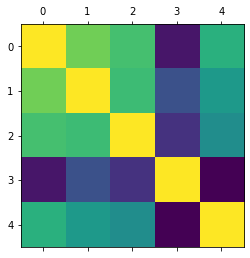

In [37]:
plt.matshow(joined_pd_lr.corr())
plt.show()